# Банки — Анализ оттока клиентов

**Автор** Пинчук Ольга

## 1. Предобработка данных


In [197]:
# Импорт требуемых библиотек
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import phik

In [198]:
# Загружаем данные
try:
    df = pd.read_csv(f'datasets/bank_dataset.csv')  # Локальный путь
except:
    df = pd.read_csv(f'/datasets/bank_dataset.csv')  # Серверный путь
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


userid  score       City Gender  Age  Objects    Balance  Products  \
0  15677338    619  Ярославль      Ж   42        2        NaN         1   
1  15690047    608    Рыбинск      Ж   41        1   83807.86         1   
2  15662040    502  Ярославль      Ж   42        8  159660.80         3   
3  15744090    699  Ярославль      Ж   39        1        NaN         2   
4  15780624    850    Рыбинск      Ж   43        2  125510.82         1   

   CreditCard  Loyalty  estimated_salary  Churn  
0           1        1         101348.88      1  
1           0        1         112542.58      0  
2           1        0         113931.57      1  
3           0        0          93826.63      0  
4           1        1          79084.10      0

1. Заголовки столбцов в разном формате- надо привести к единому
2. City - проверить на правильность написания, нет ли городов написанных с маленькой буквы
3. Есть пропуски в столбце Balance- надо посмотреть детальнее, возможно часть из них дубликатыъ
4. Gender- категория, есть смысл привести к категории 0 и 1 и привести тип к int
5. Типы данных соответствуют данным



In [199]:
# Приводим название столбцов к единому формату- прописными
df.columns = df.columns.str.lower()
df.head()

userid  score       city gender  age  objects    balance  products  \
0  15677338    619  Ярославль      Ж   42        2        NaN         1   
1  15690047    608    Рыбинск      Ж   41        1   83807.86         1   
2  15662040    502  Ярославль      Ж   42        8  159660.80         3   
3  15744090    699  Ярославль      Ж   39        1        NaN         2   
4  15780624    850    Рыбинск      Ж   43        2  125510.82         1   

   creditcard  loyalty  estimated_salary  churn  
0           1        1         101348.88      1  
1           0        1         112542.58      0  
2           1        0         113931.57      1  
3           0        0          93826.63      0  
4           1        1          79084.10      0

In [200]:
# Проверка городов
df['city'].unique()

array(['Ярославль', 'Рыбинск', 'Ростов Великий'], dtype=object)

In [201]:
# Поиск дубликатов
df.duplicated().sum()

0

- Города написаны корректно
- Дубликаты в данных не обнаружены

Доля пропусков в balance - 0.3617
Распределение balance:


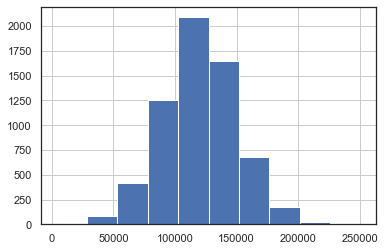

count      6383.000000
mean     119827.493793
std       30095.056462
min        3768.690000
25%      100181.975000
50%      119839.690000
75%      139512.290000
max      250898.090000
Name: balance, dtype: float64

In [202]:
# Разберемся с пропусками в balance
print('Доля пропусков в balance -',df['balance'].isna().sum()/len(df))
print('Распределение balance:')
df['balance'].hist()
plt.show()
df['balance'].describe()

[картинка](img/img1.jpg)

In [203]:
df[df['balance'].isna()].groupby(['churn']).count()

userid  score  city  gender   age  objects  balance  products  \
churn                                                                  
0        3117   3117  3117    3117  3117     3117        0      3117   
1         500    500   500     500   500      500        0       500   

       creditcard  loyalty  estimated_salary  
churn                                         
0            3117     3117              3117  
1             500      500               500

Пропуски в balance оставляем, т.к. их ~ 36% замена на среднее, медиану или 0 приведет к искажению данных.
Основное кол-во пропусков у клиентов которые не ушли.
Пропуски могли появится из-за использования клиентом продуктов не подразумивающих наличия баланса на счете, например ипотека.

In [204]:
# Заменяем значения в Gender и приводим к int
df = df.replace({'gender':{'Ж': False, 'М': True}})
df['gender'].astype('bool')
df.rename(columns={'gender': 'gender_man'}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   city              10000 non-null  object 
 3   gender_man        10000 non-null  bool   
 4   age               10000 non-null  int64  
 5   objects           10000 non-null  int64  
 6   balance           6383 non-null   float64
 7   products          10000 non-null  int64  
 8   creditcard        10000 non-null  int64  
 9   loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: bool(1), float64(2), int64(8), object(1)
memory usage: 869.3+ KB


## 2. Исследовательский анализ данных
- Изученить данные
- Посмотреть на корреляцию
- Построить графики распределения признаков
- Добавить категории, если потребуется

<AxesSubplot:title={'center':'Матрица корреляции признаков'}>

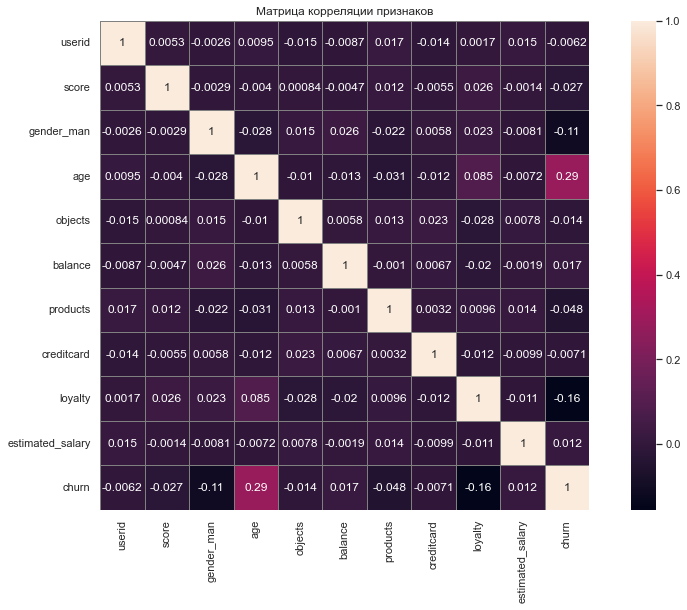

In [205]:
# Матрица корреляций Пирсона
sns.set(style='white')
plt.figure(figsize=(15, 9))
plt.title('Матрица корреляции признаков')
sns.heatmap(df.corr(), annot=True, linewidths=1, linecolor='gray', square=True)

[картинка](img/img2.jpg)

interval columns not set, guessing: ['userid', 'score', 'age', 'objects', 'balance', 'products', 'creditcard', 'loyalty', 'estimated_salary', 'churn']


<AxesSubplot:title={'center':'Матрица корреляции Фи-коэффициента:'}>

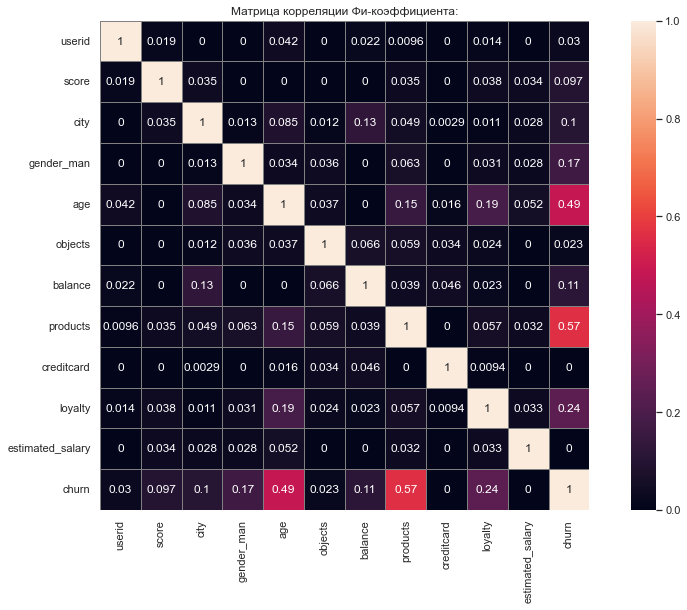

In [206]:
# Матрица корреляции Фи-коэффициента для учета нелинейных зависимостей
sns.set(style='white')
plt.figure(figsize=(15, 9))
plt.title('Матрица корреляции Фи-коэффициента:')
sns.heatmap(df.phik_matrix(), annot=True, linewidths=1, linecolor='gray', square=True)

[картинка](img/img3.jpg)

Есть слабая корреляция с кол-вом продуктов и возрастом

In [207]:
# Графики распределения признаков
churn1  = df[df['churn'] == 1]
churn0  = df[df['churn'] == 0]
for col in df.drop(['churn','userid'], axis = 1).columns:
    fig = go.Figure()
    fig.add_trace(go.Histogram(x=churn1[col], name='ушли'))
    fig.add_trace(go.Histogram(x=churn0[col], name='остались'))
    fig.update_layout(
                  title=f'Распределение {col}',
                  xaxis_title=col,
                  yaxis_title="Кол-во клиентов",
                  margin=dict(l=0, r=0, t=30, b=0),
                  height=300,
                  width=900)
    fig.show()



- [картинка 1](img/img4_1.jpg)
- [картинка 2](img/img4_1.jpg)
- [картинка 3](img/img4_1.jpg)
- [картинка 4](img/img4_1.jpg)

In [208]:
# смотрим на выбросы в некатегориальных признаках
box_list =['score','age','objects','balance','products','estimated_salary']
for col in box_list:
    fig = go.Figure()
    fig.add_trace(go.Box(x=churn1[col], name='ушели'))
    fig.add_trace(go.Box(x=churn0[col], name='остались'))
    fig.update_layout(
                  title=f'Распеделение в {col}',
                  xaxis_title="Значение признака",
                  margin=dict(l=0, r=0, t=30, b=0),
                  height=200,
                  width=900)
    fig.show()

- [картинка 1](img/img5_1.jpg)
- [картинка 2](img/img5_2.jpg)

In [209]:
# создание категории по возрасту
df['age_cat'] = pd.qcut(df['age'],4)
df['age_cat'] =df['age_cat'].astype('str')
df.head()

userid  score       city  gender_man  age  objects    balance  products  \
0  15677338    619  Ярославль       False   42        2        NaN         1   
1  15690047    608    Рыбинск       False   41        1   83807.86         1   
2  15662040    502  Ярославль       False   42        8  159660.80         3   
3  15744090    699  Ярославль       False   39        1        NaN         2   
4  15780624    850    Рыбинск       False   43        2  125510.82         1   

   creditcard  loyalty  estimated_salary  churn       age_cat  
0           1        1         101348.88      1  (37.0, 44.0]  
1           0        1         112542.58      0  (37.0, 44.0]  
2           1        0         113931.57      1  (37.0, 44.0]  
3           0        0          93826.63      0  (37.0, 44.0]  
4           1        1          79084.10      0  (37.0, 44.0]

In [210]:
age_cat = df.groupby(['age_cat'])['churn'].agg(['count', 'sum']).reset_index()
age_cat.columns =['age_cat','churn_cnt','ушло клиентов']
age_cat['доля ушедших'] = age_cat['ушло клиентов']/age_cat['churn_cnt']
print('Доля ушедших в возрастной категории')
age_cat

Доля ушедших в возрастной категории


age_cat  churn_cnt  ушло клиентов  доля ушедших
0  (17.999, 32.0]       2790            213      0.076344
1    (32.0, 37.0]       2297            249      0.108402
2    (37.0, 44.0]       2573            531      0.206374
3    (44.0, 92.0]       2340           1044      0.446154

### Выводы

На основании данных по клиентам, которые остались типичного пользователя можно определить по следующим признакам:
- баллы кредитного скоринга от 585 до 718
- возраст от 31 до 41
- количество объектов в собственности от 3 до 7 шт
- количество продуктов, которыми пользуется клиент до 2х
- клиент показывает активность
- заработная плата клиента от 50 до 148 тыс

Что касается влияния признаков на уход:
1. Заметна корреляция с возростом и loyalty(признак активного клиента)
2. В возросте до 37 лет уходят реже

## 3. Составьте портрет пользователя каждого региона
- Определить влияющие признаки
- Выдвинуть дополнительные гипотезы 
- Составить вывод с описание портрета пользователя склонного уходить по регионал

In [211]:
# Графики распределения признаков по городам
churn1  = df[df['churn'] == 1]
churn0  = df[df['churn'] == 0]
    
for col in df.drop(['churn','userid','city'], axis = 1).columns:
    fig = make_subplots(rows=1, cols=3, subplot_titles=('Ярославль', 'Рыбинск','Ростов Великий'), shared_yaxes=True)
    fig.add_trace(go.Histogram(x=churn1[churn1['city'] == 'Ярославль'][col], name='ушли Ярославль'),1,1)
    fig.add_trace(go.Histogram(x=churn0[churn0['city'] == 'Ярославль'][col], name='остались Ярославль'),1,1)


    fig.add_trace(go.Histogram(x=churn1[churn1['city'] == 'Рыбинск'][col], name='ушли Рыбинск'),1,2)
    fig.add_trace(go.Histogram(x=churn0[churn0['city'] == 'Рыбинск'][col], name='остались Рыбинск'),1,2)

    fig.add_trace(go.Histogram(x=churn1[churn1['city'] == 'Ростов Великий'][col], name='ушли Ростов'),1,3)
    fig.add_trace(go.Histogram(x=churn0[churn0['city'] == 'Ростов Великий'][col], name='остались Ростов'),1,3)

    fig.update_layout(
                  title=f'Распределение {col}',
                  
                  yaxis_title="Кол-во клиентов",
                  margin=dict(l=0, r=0, t=30, b=0),
                  height=400,
                  width=1000)
    fig.show()


- [картинка 1](img/img6_1.jpg)
- [картинка 2](img/img6_2.jpg)
- [картинка 3](img/img6_3.jpg)
- [картинка 4](img/img6_4.jpg)
- [картинка 5](img/img6_5.jpg)



In [212]:
city = df.groupby('city')['churn'].agg(['count', 'sum']).reset_index()
city['доля ушедших'] = city['sum']/city['count']
print('Доля ушедших в городе')
city

Доля ушедших в городе


city  count  sum  доля ушедших
0  Ростов Великий   2509  814      0.324432
1         Рыбинск   2477  413      0.166734
2       Ярославль   5014  810      0.161548

### Вывод
- По Ярославлю данных в 2 раза больше, чем по остальным городам, допустим в Ярославле просто больше клиентов, т.к. предположить иное без указания временного среза нет возможности
- В Ростове больше доля ушедших- почти 30%, когда в остальных городах только 16%
- В Ростове значительно больше выражен уход клиентов с балансом 100-150тыс
- В Ростове больше доля ушедших среди тех у кого есть кредитка
- В ростове больше доля неактивных и ушедших
- В Ростове среди ушедших преобладает возастнастная группа старше 44, в этой возрасной группе ушло больше, чем осталось


**Дополнительные гипотезы для проверки**
1. Пользователи в возрасте старше 37 уходят чаще.

## 4. Проверьте гипотезы 
- Проверка гипотезы различия дохода между теми клиентами, которые ушли и теми, которые остались
- Проверка гипотезы выдвинутой в п.4

### Формулирование гипотез
1. Различия дохода между теми клиентами, которые ушли и теми, которые остались
---- H0 - доход не различается
---- H1 - доход различается
2. Пользователи в возрасте старше 37 уходят чаще? Т.е. есть различия в возрасте среди тех кто ушел и кто остался
---- H0 - различий в возрасте нет
---- H1 - есть различия в возрасте

In [213]:

def test_student(alpha_levin,alpha_ttest, list1,list2):
#Тест Левена для сравнения дисперсий. Если pvalue будет больше порога 0,05, то дисперсии можно считать равными
    leven = st.levene(list1, list2)
    print(leven.pvalue)
    if leven.pvalue < alpha_levin:
        print("Дисперсии выборок не отличаются -> при тесте Стьюдента устанавливаем параметр equal_var = True")
        results = st.ttest_ind(list1, list2, equal_var = True)
        print('p-значение:', results.pvalue)
        if results.pvalue < alpha_ttest:
            print("Отвергаем нулевую гипотезу. Различий нет")
        else: 
            print("Не получилось отвергнуть нулевую гипотезу. Различия есть")
    else: 
        print("Дисперсии выборок отличаются значимо -> при тесте Стьюдента устанавливаем параметр equal_var = False")
        results = st.ttest_ind(list1, list2, equal_var = False)
        print('p-значение:', results.pvalue)
        if results.pvalue < alpha_ttest:
            print("Отвергаем нулевую гипотезу. Различий нет")
        else: 
            print("Не получилось отвергнуть нулевую гипотезу. Различия есть")

    

In [214]:
test_student(0.05,0.01, df[df['churn']== 1]['age'],df[df['churn']== 0]['age'])

0.00030692323049423515
Дисперсии выборок не отличаются -> при тесте Стьюдента устанавливаем параметр equal_var = True
p-значение: 1.2399313093427738e-186
Отвергаем нулевую гипотезу. Различий нет


In [215]:
test_student(0.05,0.05, df[df['churn']== 1]['estimated_salary'],df[df['churn']== 0]['estimated_salary'])

0.3379824239075462
Дисперсии выборок отличаются значимо -> при тесте Стьюдента устанавливаем параметр equal_var = False
p-значение: 0.22892461305145803
Не получилось отвергнуть нулевую гипотезу. Различия есть


In [216]:
# U-тест Манна-Уитни
def test_mann(alpha, list1,list2):
    results = st.mannwhitneyu(list1, list2)
    print('p-значение:', results.pvalue)
    if results.pvalue < alpha:
        print("Отвергаем нулевую гипотезу. Различий нет")
    else: 
        print("Не получилось отвергнуть нулевую гипотезу. Различия есть")


In [217]:
test_mann(0.05, df[df['churn']== 1]['estimated_salary'],df[df['churn']== 0]['estimated_salary'])

p-значение: 0.22705150930153783
Не получилось отвергнуть нулевую гипотезу. Различия есть


### Результат проверки гипотез
1. Есть различия в зарплате между теми кто ушел и теми кто остался
2. Нет различий в возрасте между теми кто ушел и теми кто остался

## Шаг 6. Общий вывод

**Общий портрет пользователя**
На основании данных по клиентам, которые остались типичного пользователя можно определить по следующим признакам:
- баллы кредитного скоринга от 585 до 718
- возраст от 31 до 41
- количество объектов в собственности от 3 до 7 шт
- количество продуктов, которыми пользуется клиент до 2х
- клиент показывает активность
- заработная плата клиента от 50 до 148 тыс

Что касается влияния признаков на уход:
1. Есть слабая корреляция с кол-вом продуктов и возрастом
2. В возросте до 37 лет уходят реже

 **Портрет пользователя склонного уходить по городам**
- В Ростове больше доля ушедших- почти 30%, когда в остальных городах только 16%
- В Ростове значительно больше выражен уход клиентов с балансом 100-150тыс
- В Ростове больше доля ушедших среди тех у кого есть кредитка
- В Ростове больше доля неактивных и ушедших
- В Ростове среди ушедших преобладает возрастная группа старше 44, в этой возрасной группе ушло больше, чем осталось


 **Результат проверки гипотез**
1. Есть различия в зарплате между теми кто ушел и теми кто остался
2. Нет различий в возрасте между теми кто ушел и теми кто остался

**Предложения**
1. Усилисть клиентский отдел в Ростове для снижения оттока, и пересмотреть политику кредитного отдела. 
2. Нужно более детально изучить сервис(личный кабинет и мобильное приложение), возможно клиентам не удобно вносить ежемесячную оплату. Если пользователям не удобно регулярно взаимодействовать с банком, то понятно почему они уходят.
3. Внедрить социальные пакеты услуг, например пенсия в нашем банке, кэшбек за покупки, бонусы для зарплатных клиентов(например сниженная ставка по кредиту)
4. Добавить услугу персонального менеджера
5. Собрать обратную связь от пользователей попадающих под портрет склоннох к уходу для доп.анализа + предложить дополнительные продукты

 